# Code to implement ANN for Zheng 68k dataset

(10-22-2020)
- implementing ANN with Tensorflow/Keras instead of PyTorch

(10-23-2020)
- tried 10 epochs w/ 16 (instead of 500) as batch size. Still about 23% accuracy on test data.
- removing dropouts in the init method and added method for normalization/scaling
- note: removing all genes with 0 counts and using normalized logCPM does not improve test accuracy
- Realized that using to_categorical separately on train/test data mixes up the labels.
- one 200 node layer gives about 65% accuracy on test data

(10-24-2020)
- created method to convert binary class matrices back to class vectors 
- class vectors can now be used to create confusion matrices (true labels, predicted labels)
- created method to take the max. probability cell type assignment from model.predict as the cell type prediction
- Added demo and general workflow summary

In [1]:
import numpy as np
import pandas as pd
import scipy.io as io
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# path = path to the 10Xv2 data directory containing genes.tsv, barcodes.tsv, and matrix.mtx files
# Note: need to import cell type annotations file manually since annotation files do not 
# have any set format between datasets. Set index names to cell barcode IDs in the annotation dataframe
# and have the celltype annotations as the first column.

class sctype:
    def __init__(self, path):
        self.genes = pd.read_csv(path + 'genes.tsv', sep = '\t', header = None).iloc[:,1]
        self.barcodes = pd.read_csv(path + 'barcodes.tsv', sep = '\t', header = None).iloc[:,0]
        expression = io.mmread(path + 'matrix.mtx') 
        
        data = pd.DataFrame.sparse.from_spmatrix(data = expression, index = self.genes, columns = self.barcodes)
        data = data.fillna(0)
        gene_counts = data.sum(axis = 1)
        data = data[gene_counts != 0]
        
        self.data = data.transpose()
        self.dropouts = gene_counts[gene_counts == 0].index
    
    
# This preprocess step will divide the gene counts by the total counts per cell, multiply by scale_factor
# and perform log1p; output is normalized logCPM data. 
# Scale will center the per gene expression data around 0 and adjust to unit variance.
# Though, this doesn't seem to affect NN performance too much. Can feed self.data to the split method
# and go directly to training the NN without running this preprocessing step.

    def data_preprocess(self, normalize = True, scale_factor = 10000, scale = True):
        if normalize:
            cell_counts = self.data.sum(axis = 1)
            div = self.data.divide(other = cell_counts, axis = 'index')
            self.data_norm = np.log1p(div * scale_factor)
        if scale:
            if normalize:
                self.data_norm = (self.data_norm - np.mean(self.data_norm, axis = 0))\
                /(np.std(self.data_norm, axis = 0))
            else:
                self.data_scaled = (self.data - np.mean(self.data, axis = 0))\
                /(np.std(self.data, axis = 0))

                
# Labels input should be a dataframe with cell barcode IDs as indices and celltype annotations 
# in the first column. This will convert labels with one-hot encoding for use as labels in the NN
# must be done BEFORE splitting into train/test sets.

# The key to the one-hot encoded labels will be stored in self.key
# The original labels will be stored in self.labels

    def process_labels(self, labels):
        labels[labels == ['CD4+/CD45RO+ Memory']] = 'CD4+ T' 
        labels[labels == ['CD4+/CD25 T Reg']] = 'CD4+ T' 
        labels[labels == ['CD4+ T Helper2']] = 'CD4+ T' 
        labels[labels == ['CD4+/CD45RA+/CD25- Naive T']] = 'CD4+ T' 
        labels[labels == ['CD8+ Cytotoxic T']] = 'CD8+ T'
        labels[labels == ['CD8+/CD45RA+ Naive Cytotoxic']] = 'CD8+ T'
        
        factorized = pd.factorize(labels.iloc[:,0])
        self.labels = labels
        self.key = factorized[1]
        self.categorical_labels = to_categorical(factorized[0], len(factorized[1]))
    
    def split(self, data, test_size, random_state):
        self.train_data, self.test_data, self.train_labels, self.test_labels = train_test_split(
            data, self.categorical_labels, test_size=test_size,
            random_state=random_state, stratify=self.categorical_labels)
    
    def ann(self, epochs, batch_size):
        model = keras.Sequential()
        model.add(layers.Dense(200, activation='relu', name = 'layer1'))
        model.add(layers.Dense(100, activation='relu', name = 'layer2'))
        model.add(layers.Dense(len(self.key), activation='softmax', name = 'outputlayer'))
        
        model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
    
        model.fit(self.train_data, self.train_labels, epochs=epochs, batch_size=batch_size)
            
        self.ann_fit = model
        return self.ann_fit
    
    
# Converts the binary class matrix (created from to_categorical) back to a class vector with
# integeters representing the different classes. The order of the labels are stored in self.key

    def to_vector(self, class_matrix):
        copy_matrix = class_matrix.copy()
        for i in range(len(copy_matrix[0])):
            copy_matrix[:,i] = copy_matrix[:,i] * (i+1)
        tmp = []
        for j in range(len(copy_matrix)):
            tmp.append(np.trim_zeros(copy_matrix[j]))
        class_vector = np.concatenate(tmp)
        return class_vector
    
    
# From the output of model.predict, select highest probabilities per cell as the celltype prediction

    def max_prob(self, probs):
        predictions = (probs == probs.max(axis = 1)[:,None]).astype(int)
        return predictions

## Demonstration of importing/processing data and training the ANN
### General workflow:
1. __Define path to annotation and data files__ (in format of 10X v2 data with genes.tsv, barcodes.tsv, and matrix.mtx files)
2. __import and process annotation file__ to have barcodes as indices and cell type labels in first column
3. __Create sctype object__, given the path to the data files
4. __Process the labels__; this will create self.labels which retains original annotation information, but also creates one-hot encoded labels to be used for the neural network. self.key has all of the unique cell types being annotated
5. __Preprocess counts data__(optional); this doesn't seem to have much of an affect with this intra-dataset evaluation on test data. But this will divide counts by total counts per cell, log-normalize (with log1p), and center feature data around 0.
6. __Split the data__ to create separate train/test datasets with respective labels
7. __Train the NN__ with # of epochs and batch size provided as input to the self.ann() method.
8. __Evaluate performance of NN__
9. __Generate cell type predictions__ with self.ann_fit.predict()
10. __Convert prediction probabilities to cell type labels__ with self.max_prob followed by self.to_vector. This will provide a class vector with each integeter representing a cell type (actual cell type names stored in self.key)

In [2]:
# 1 and 2. Define annotation and data file paths and import labels. 
path_data = '/Users/leealj/py_projects/biof509_final/zheng68k/filtered_matrices_mex/hg19/'
path_anno = '/Users/leealj/py_projects/biof509_final/zheng68k/'

labels = pd.read_csv(path_anno + '68k_pbmc_barcodes_annotation.tsv', sep = '\t').loc[:,["barcodes","celltype"]]
labels.set_index("barcodes", inplace = True)

In [3]:
# 3 and 4. Create sctype object, given path to the data files and process labels
zheng = sctype(path_data)
zheng.process_labels(labels)

In [4]:
# 5. Data pre-processing step to calculate logCPM counts and center around 0 with unit variance.
zheng.data_preprocess(normalize = True, scale = True)

In [5]:
# 6. Split the expression data into a train set and test set with their respective labels
zheng.split(data = zheng.data_norm, test_size = 0.25, random_state = 40)

In [6]:
# 7. train the NN with the training dataset from split
zheng.ann(5, 32) 

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1608/1608 [==============================] - 39s 24ms/step - loss: 0.5718 - accuracy: 0.7854
Epoch 2/5
1608/1608 [==============================] - 39s 24ms/step - loss: 0.1575 - accuracy: 0.9417
Epoch 3/5
1608/1608 [==============================] - 32s 20ms/step - loss: 0.0494 - accuracy: 0.9841
Epoch 4/5
1608/1608 [==============================] - 30s 18ms/step - loss: 0.0448 - accuracy: 0.9861
Epoch 5/5
1608/1608 [==============================] - 34s 21ms/step - loss: 0.0444 - accuracy: 

In [7]:
# 8. Use train dataset from split to test the NN
score_train = zheng.ann_fit.evaluate(zheng.train_data, zheng.train_labels, verbose=1)
print('training loss=', score_train[0]) 
print('training accuracy=', score_train[1]) 

1608/1608 [==============================] - 20s 12ms/step - loss: 0.0151 - accuracy: 0.9954
training loss= 0.015109247528016567
training accuracy= 0.9954310655593872


In [8]:
# 8. Use test dataset from split to test the NN
score = zheng.ann_fit.evaluate(zheng.test_data, zheng.test_labels, verbose=1)
print('test loss=', score[0]) 
print('test accuracy=', score[1]) 

536/536 [==============================] - 4s 8ms/step - loss: 1.1120 - accuracy: 0.7964
test loss= 1.111951231956482
test accuracy= 0.796383798122406


In [9]:
# 9. Make the cell type predictions with trained NN
test_probs = zheng.ann_fit.predict(zheng.test_data)

In [25]:
# 10. Select highest probabilities per cell from NN as the cell type prediction
test_pred = zheng.max_prob(test_probs)
test_pred = zheng.to_vector(test_probs)
print(np.unique(test_pred))
print(zheng.key)

[1 2 3 4 5 6 7]
Index(['CD8+ T', 'CD4+ T', 'CD19+ B', 'CD56+ NK', 'CD34+', 'Dendritic',
       'CD14+ Monocyte'],
      dtype='object')


In [26]:
# Create confusion matrix to evaluate performance of NN
from sklearn.metrics import confusion_matrix

test_true = zheng.to_vector(zheng.test_labels)
# (target, predictions)
confusion_matrix(test_true, test_pred)

array([[7929,  847,  315,  243,    8,   11,    7],
       [ 987, 1731,   71,    1,    1,   11,    3],
       [ 343,   67, 1058,    0,    1,    8,    0],
       [ 284,    4,    0, 1902,    0,    2,    2],
       [   0,    0,    2,    0,   66,    1,    0],
       [   9,    6,   12,    0,    0,  338,  160],
       [   0,    2,    0,    0,    0,   83,  630]])

In [ ]:
# Cell type probabilities split by true cell type labels
# to be used for violin plots

predict1 = test_probs[np.where(test_true == 1)]
predict2 = test_probs[np.where(test_true == 2)]
predict3 = test_probs[np.where(test_true == 3)]
predict4 = test_probs[np.where(test_true == 4)]
predict5 = test_probs[np.where(test_true == 5)]
predict6 = test_probs[np.where(test_true == 6)]
predict7 = test_probs[np.where(test_true == 7)]

## Generating heatmaps and violin plots

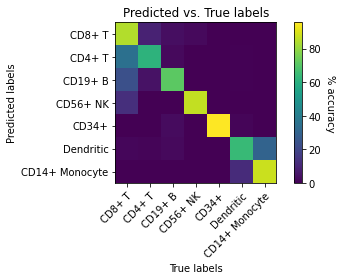

In [90]:
import matplotlib
import matplotlib.pyplot as plt

confmatrix = confusion_matrix(test_true, test_pred, normalize = 'true')

fig, ax = plt.subplots()
im = ax.imshow(confmatrix*100)

ax.set_xticks(np.arange(len(zheng.key)))
ax.set_yticks(np.arange(len(zheng.key)))

ax.set_xticklabels(zheng.key)
ax.set_yticklabels(zheng.key)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("% accuracy", rotation=-90, va="bottom")

ax.set_ylabel("Predicted labels")
ax.set_xlabel("True labels")
ax.set_title("Predicted vs. True labels")
fig.tight_layout()
plt.savefig(fname = '/Users/leealj/py_projects/biof509_final/nn_heatmap.png', dpi = 500, transparent = True)
plt.show()

In [83]:
fs = 10  # fontsize
pos = [1, 2, 4, 5, 7, 8]
data = [np.random.normal(0, std, size=100) for std in pos]

In [87]:
test_probs[np.where(test_true == 2)][0]

array([9.9992287e-01, 7.6978991e-05, 2.0395074e-08, 3.5767496e-09,
       5.7512025e-13, 6.1337211e-08, 6.6432710e-13], dtype=float32)

In [ ]:
[np.where(test_pred) == 1] # Indices of all cells that were predicted to be CD8+ T
test_prob[np.where(test_pred) == 1] # Prediction probabilities (for all cell types) of all cells that were predicted to be CD8+ T
# plot these values on violin plot... So there will be 7 violin plots in total.